<a href="https://colab.research.google.com/github/MonoHaru/testGit/blob/main/%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98(PyTorch)_%EA%B8%B0%EC%B4%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

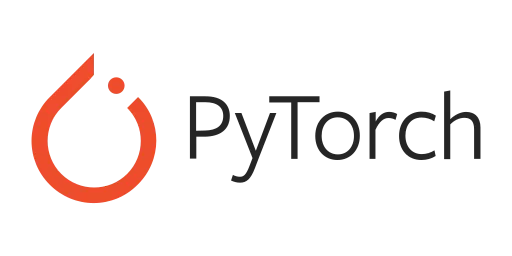

# 파이토치(PyTorch)

* 페이스북이 초기 루아(Lua) 언어로 개발된 토치(Torch)를 파이썬 버전으로 개발하여 2017년도에 공개
* 초기에 토치(Torch)는 넘파이(NumPy) 라이브러리처럼 과학 연산을 위한 라이브러리로 공개
* 이후 GPU를 이용한 텐서 조작 및 동적 신경망 구축이 가능하도록 딥러닝 프레임워크로 발전시킴
* 파이썬답게 만들어졌고, 유연하면서도 가속화된 계산 속도를 제공

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 파이토치 모듈 구조

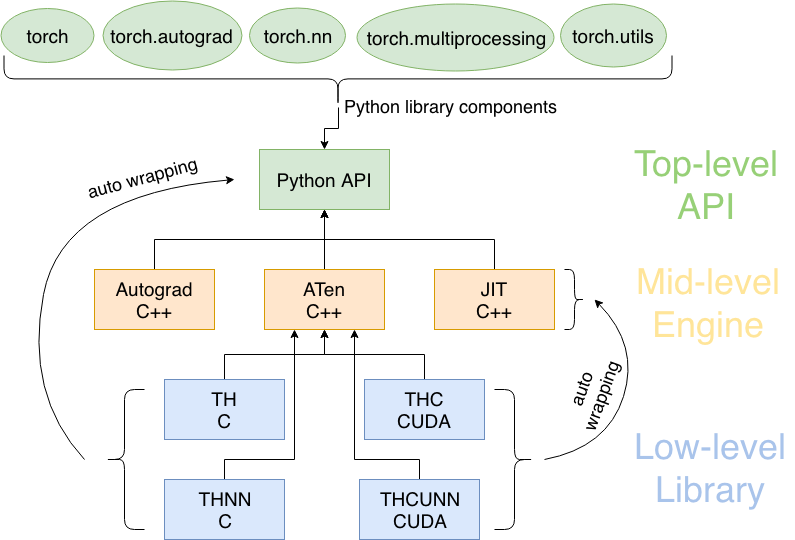

<small>출처: Deep Learning with PyTorch by Eli Stevens Luca Antiga. MEAP Publication. https://livebook.manning.com/#!/book/deep-learning-with-pytorch/welcome/v-7/</small>

## 파이토치의 구성요소

- `torch`: 메인 네임스페이스, 텐서 등의 다양한 수학 함수가 포함
- `torch.autograd`: 자동 미분 기능을 제공하는 라이브러리
- `torch.nn`: 신경망 구축을 위한 데이터 구조나 레이어 등의 라이브러리
- `torch.multiprocessing`: 병럴처리 기능을 제공하는 라이브러리
- `torch.optim`: SGD(Stochastic Gradient Descent)를 중심으로 한 파라미터 최적화 알고리즘 제공
- `torch.utils`: 데이터 조작 등 유틸리티 기능 제공
- `torch.onnx`: ONNX(Open Neural Network Exchange), 서로 다른 프레임워크 간의 모델을 공유할 때 사용

In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F

GPU 설정

In [65]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## 데이터 준비

파이토치에서는 데이터 준비를 위해 `torch.utils.data`의 `Dataset`과 `DataLoader` 사용 가능

- `Dataset`에는 다양한 데이터셋이 존재 (MNIST, FashionMNIST, CIFAR10, ...)
  - Vision Dataset: https://pytorch.org/vision/stable/datasets.html
  - Text Dataset: https://pytorch.org/text/stable/datasets.html
  - Audio Dataset: https://pytorch.org/audio/stable/datasets.html
- `DataLoader`와 `Dataset`을 통해 `batch_size`, `train` 여부, `transform` 등을 인자로 넣어 데이터를 어떻게 load할 것인지 정해줄 수 있음

In [66]:
from torch.utils.data import Dataset, DataLoader

토치비전(`torchvision`)은 파이토치에서 제공하는 데이터셋들이 모여있는 패키지

- `transforms`: 전처리할 때 사용하는 메소드 (https://pytorch.org/docs/stable/torchvision/transforms.html)
- `transforms`에서 제공하는 클래스 이외는 일반적으로 클래스를 따로 만들어 전처리 단계를 진행


In [67]:
import torchvision.transforms as transforms
from torchvision import datasets

`DataLoader`의 인자로 들어갈 `transform`을 미리 정의할 수 있고, `Compose`를 통해 리스트 안에 순서대로 전처리 진행

`ToTensor`()를 하는 이유는 `torchvision`이 PIL Image 형태로만 입력을 받기 때문에 데이터 처리를 위해서 Tensor형으로 변환 필요

In [ ]:
mnist_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize(mean=(0.5, ), std=(1.0, ))])

In [ ]:
trainset = datasets.MNIST(root='/content',
                          train=True,
                          download=True,
                          transform=mnist_transform)

testset = datasets.MNIST(root='/content',
                          train=False,
                          download=True,
                          transform=mnist_transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



`DataLoader`는 데이터 전체를 보관했다가 실제 모델 학습을 할 때 `batch_size` 크기만큼 데이터를 가져옴

In [ ]:
train_loader = DataLoader(trainset, batch_size=8, shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=8, shuffle=False, num_workers=2)

In [ ]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images.shape, labels.shape

(torch.Size([8, 1, 28, 28]), torch.Size([8]))

In [ ]:
torch_image = torch.squeeze(images[0])
torch_image.shape

torch.Size([28, 28])

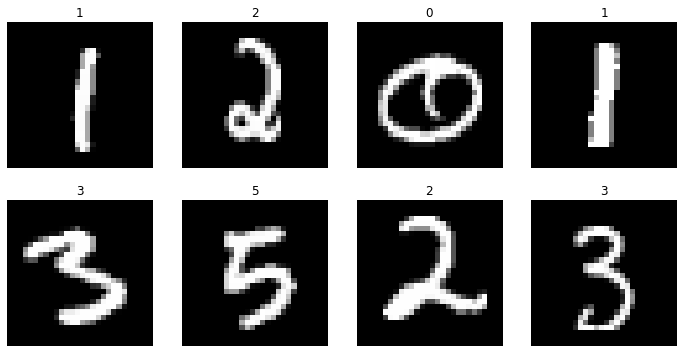

In [ ]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(12, 6))
cols, rows = 4, 2
for i in range(1, cols * rows + 1):
  idx = torch.randint(len(trainset), size=(1, )).item()
  img, label = trainset[idx]
  figure.add_subplot(rows, cols, i)
  plt.title(label)
  plt.axis('off')
  plt.imshow(img.squeeze(), cmap='gray')
plt.show()

## 모델 정의

- 레이어(layer): 신경망의 핵심 데이터 구조로 하나 이상의 텐서를 입력받아 하나 이상의 텐서를 출력
- 모듈(module): 한 개 이상의 레이어가 모여서 구성
- 모델(model): 한 개 이상의 모듈이 모여서 구성



`nn.Module` 상속 클래스 정의
- `__init__()`: 모델에서 사용될 모듈과 활성화 함수 등을 정의
- `forward()`: 모델에서 실행되어야 하는 연산을 정의

In [ ]:
class DNN(nn.Module):
  def __init__(self):
    super(DNN, self).__init__()
    self.fc1 = nn.Linear(in_features=784, out_features=256)
    self.drop = nn.Dropout(0.3)
    self.fc2 = nn.Linear(in_features=256, out_features=128)
    self.fc3 = nn.Linear(in_features=128, out_features=10)

  def forward(self, inputs):
    out = inputs.view(-1, 784)
    out = F.relu(self.fc1(out))
    out = self.drop(out)
    out = F.relu(self.fc2(out))
    out = self.fc3(out)
    return out

In [ ]:
model = DNN().to(device)
print(list(model.children()))
print()
print(list(model.modules()))

[Linear(in_features=784, out_features=256, bias=True), Dropout(p=0.3, inplace=False), Linear(in_features=256, out_features=128, bias=True), Linear(in_features=128, out_features=10, bias=True)]

[DNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
), Linear(in_features=784, out_features=256, bias=True), Dropout(p=0.3, inplace=False), Linear(in_features=256, out_features=128, bias=True), Linear(in_features=128, out_features=10, bias=True)]


## 모델 파라미터


### 손실 함수(Loss function)

* 예측 값과 실제 값 사이의 오차 측정
* 학습이 진행되면서 해당 과정이 얼마나 잘 되고 있는지 나타내는 지표
* 모델이 훈련되는 동안 최소화될 값으로 주어진 문제에 대한 성공 지표
* 손실 함수에 따른 결과를 통해 학습 파라미터를 조정
* 최적화 이론에서 최소화 하고자 하는 함수
* 미분 가능한 함수 사용
* 파이토치의 주요 손실 함수
  - `torch.nn.BCELoss`: 이진 분류를 위해 사용
  - `torch.nn.CrossEntropyLoss`: 다중 클래스 분류를 위해 사용
  - `torch.nn.MSELoss`: 회귀 모델에서 사용

In [ ]:
criterion = nn.CrossEntropyLoss()

### 옵티마이저(Optimizer)

* 손실 함수를 기반으로 모델이 어떻게 업데이트되어야 하는지 결정 (특정 종류의 확률적 경사 하강법 구현)
* optimizer는 `step()`을 통해 전달받은 파라미터를 모델 업데이트
* 모든 옵티마이저의 기본으로 `torch.optim.Optimizer(params, defaults)` 클래스 사용
* `zero_grad()`를 이용해 옵티마이저에 사용된 파라미터들의 기울기를 0으로 설정
* `torch.optim.lr_scheduler`를 이용해 에포크(epochs)에 따라 학습률(learning rate) 조절
* 파이토치의 주요 옵티마이저: `optim.Adadelta`, `optim.Adagrad`, `optim.Adam`, `optim.RMSprop`, `optim.SGD`

In [68]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

<img src="https://img1.daumcdn.net/thumb/R720x0.q80/?scode=mtistory2&fname=http%3A%2F%2Fcfile25.uf.tistory.com%2Fimage%2F222B4F4F562BD0330EA41C">

### 학습률 스케줄러(Learning rate scheduler)

* 학습시 특정 조건에 따라 학습률을 조정하여 최적화 진행
* 일정 횟수 이상이 되면 학습률을 감소(decay)시키거나 전역 최소점(global minimum) 근처에 가면 학습률을 줄이는 등
* 파이토치의 학습률 스케줄러 종류
  - `optim.lr_scheduler.LambdaLR`: 람다(lambda) 함수를 이용해 그 결과를 학습률로 설정
  - `optim.lr_scheduler.StepLR`: 단계(step)마다 학습률을 감마(gamma) 비율만큼 감소
  - `optim.lr_scheduler.MultiStepLR`: `StepLR`과 비슷하지만 특정 단계가 아니라 지정된 에포크에만 감마 비율로 감소
  - `optim.lr_scheduler.ExponentialLR`: 에포크마다 이전 학습률에 감마만큼 곱함
  - `optim.lr_scheduler.CosineAnnealingLR`: 학습률을 코사인(cosine) 함수의 형태처럼 변화시켜 학습률일 커지기도 하고 작아지기도 함
  - `optim.lr_scheduler.ReduceLROnPlateau`: 학습이 잘되는지 아닌지에 따라 동적으로 학습률 변화

## 모델 학습

In [ ]:
loss_history = []
acc_history = []

for epoch in range(20):

  running_loss = 0.0
  running_corrects = 0

  for i, data in enumerate(train_loader, 0):
    inputs, labels = data[0].to(device), data[1].to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    _, preds = torch.max(outputs, 1)
    loss.backward()
    optimizer.step()

    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)

  epoch_loss = running_loss / len(train_loader.dataset)
  epoch_acc = running_corrects.to('cpu').numpy() / len(train_loader.dataset)
  print('Epoch: {}, Loss: {:.5}, Acc: {:.5f}' .format(epoch+1, epoch_loss, epoch_acc))

  loss_history.append(epoch_loss)
  acc_history.append(epoch_acc)

Epoch: 1, Loss: 0.18399, Acc: 0.94455
Epoch: 2, Loss: 0.15149, Acc: 0.95423
Epoch: 3, Loss: 0.13069, Acc: 0.96055
Epoch: 4, Loss: 0.11688, Acc: 0.96465
Epoch: 5, Loss: 0.10771, Acc: 0.96670
Epoch: 6, Loss: 0.095747, Acc: 0.97038
Epoch: 7, Loss: 0.088802, Acc: 0.97237
Epoch: 8, Loss: 0.083045, Acc: 0.97390
Epoch: 9, Loss: 0.079492, Acc: 0.97542
Epoch: 10, Loss: 0.073959, Acc: 0.97648
Epoch: 11, Loss: 0.069961, Acc: 0.97850
Epoch: 12, Loss: 0.066677, Acc: 0.97828
Epoch: 13, Loss: 0.063593, Acc: 0.97983
Epoch: 14, Loss: 0.061035, Acc: 0.98078
Epoch: 15, Loss: 0.056789, Acc: 0.98133
Epoch: 16, Loss: 0.054693, Acc: 0.98237
Epoch: 17, Loss: 0.050988, Acc: 0.98348
Epoch: 18, Loss: 0.048634, Acc: 0.98410
Epoch: 19, Loss: 0.049695, Acc: 0.98313
Epoch: 20, Loss: 0.045112, Acc: 0.98543


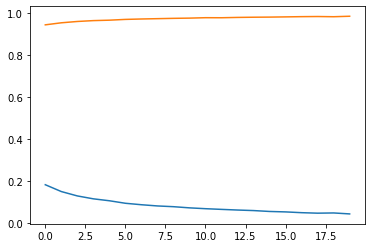

In [ ]:
plt.plot(loss_history)
plt.plot(acc_history)
plt.show()

## 모델의 저장 및 로드

- `torch.save`: `state_dict()`를 저장
- `torch.load`: `load_state_dict`로 모델을 로드

In [ ]:
PATH = './mnist.pth'
torch.save(model.state_dict(), PATH)

In [ ]:
model = DNN()
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
model.parameters

<bound method Module.parameters of DNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)>

## 모델 평가

In [ ]:
import numpy as np

def imshow(image):
  image = image / 2 + 0.5
  npimg = image.numpy()

  fig = plt.figure(figsize=(16, 8))
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

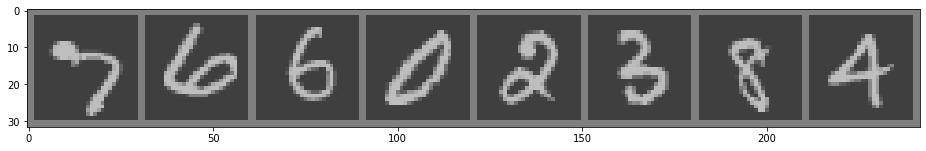

In [ ]:
import torchvision

dataiter = iter(test_loader)
iamges, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

In [ ]:
outputs = model(images)
_, predicted = torch.max(outputs, 1)
print(predicted)

tensor([7, 6, 6, 0, 2, 3, 8, 4])


In [ ]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    images, labels = data
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print(100 * correct / total)

97.43


# FashionMNIST 분류 모델

## 데이터 준비

In [82]:
import torchvision.transforms as transforms
from torchvision import datasets

transforms = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((0.5, ), (0.5, ))])

In [83]:
trainset = datasets.FashionMNIST(root='/content',
                                 train=True,
                                 download=True,
                                 transform=transforms)
testset = datasets.FashionMNIST(root='/content',
                                 train=False,
                                 download=True,
                                 transform=transforms)

In [84]:
train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

In [85]:
images, labels = next(iter(train_loader))
images.shape, labels.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

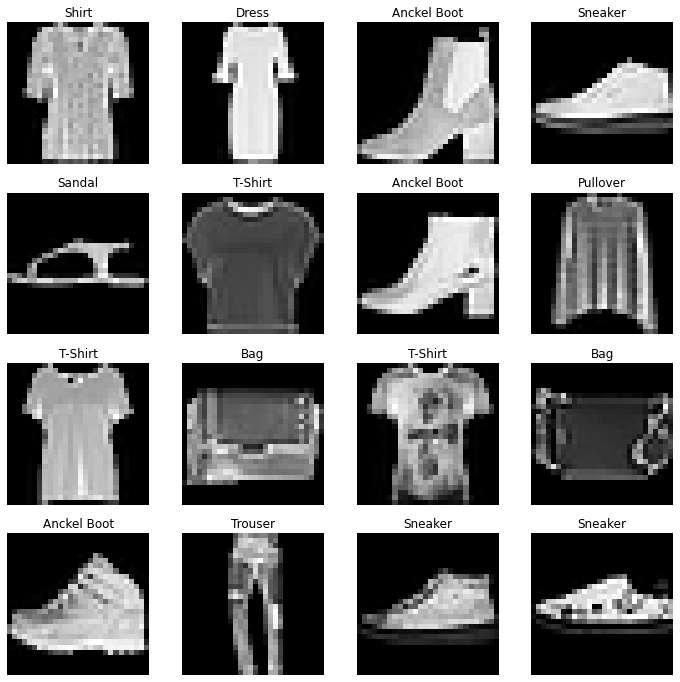

In [86]:
labels_map = {
    0: 'T-Shirt', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat',
    5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Anckel Boot'
}

figure = plt.figure(figsize=(12, 12))
cols, rows = 4, 4
for i in range(1, cols * rows +1):
  image = images[i].squeeze()
  label_idx = labels[i].item()
  label = labels_map[label_idx]

  figure.add_subplot(rows, cols, i)
  plt.title(label)
  plt.axis('off')
  plt.imshow(image, cmap='gray')

plt.show()

## 모델 정의 및 파라미터

`nn.Sequential`을 이용한 신경망 정의
- `nn.Sequential` 객체로 그 안에 각 모듈을 순차적으로 실행
- `__init__()`에서 사용할 네트워크 모델들을 `nn.Sequential`로 정의 가능
- `forward()`에서 실행되어야 할 계산을 가독성 높게 작성 가능

In [121]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.cn1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.cn2 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
    self.drop = nn.Dropout2d(0.25)
    self.fc2 = nn.Linear(in_features=600, out_features=120)
    self.fc3 = nn.Linear(in_features=120, out_features=10)

  def forward(self, inputs):
    out = self.cn1(inputs)
    out = self.cn2(out)
    out = out.view(out.size(0), -1)
    out = self.fc1(out)
    out = self.drop(out)
    out = self.fc2(out)
    out = self.fc3(out)
    return out

model = CNN().to(device)
print(model)

CNN(
  (cn1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cn2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [122]:
criteraion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## 모델 학습

In [123]:
loss_history = []
acc_history = []

for epoch in range(10):

  running_loss = 0.0
  running_corrects = 0

  for i, data in enumerate(train_loader, 0):
    inputs, labels = data[0].to(device), data[1].to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    _, preds = torch.max(outputs, 1)
    loss.backward()
    optimizer.step()

    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)

  epoch_loss = running_loss / len(train_loader.dataset)
  epoch_acc = running_corrects.to('cpu').numpy() / len(train_loader.dataset)
  print('Epoch: {}, Loss: {:.5}, Acc: {:.5f}' .format(epoch+1, epoch_loss, epoch_acc))

  loss_history.append(epoch_loss)
  acc_history.append(epoch_acc)

Epoch: 1, Loss: 0.70769, Acc: 0.76645
Epoch: 2, Loss: 0.40432, Acc: 0.85817
Epoch: 3, Loss: 0.3475, Acc: 0.87715
Epoch: 4, Loss: 0.31264, Acc: 0.88995
Epoch: 5, Loss: 0.29307, Acc: 0.89713
Epoch: 6, Loss: 0.2758, Acc: 0.90232
Epoch: 7, Loss: 0.262, Acc: 0.90698
Epoch: 8, Loss: 0.24959, Acc: 0.91087
Epoch: 9, Loss: 0.24156, Acc: 0.91477
Epoch: 10, Loss: 0.23096, Acc: 0.91825


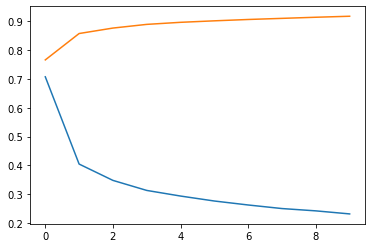

In [124]:
plt.plot(loss_history)
plt.plot(acc_history)
plt.show()

## 모델 평가

In [125]:
def imshow(image):
  image = image / 2 + 0.5
  npimg = image.numpy()

  fig = plt.figure(figsize=(16, 8))
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

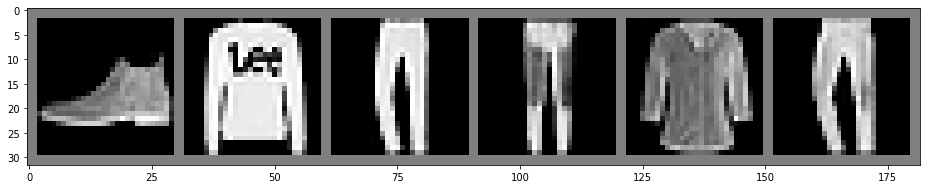

In [127]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[:6]))

In [128]:
images = images.to(device)
labels = labels.to(device)

outputs = model(images)

_, predicted = torch.max(outputs, 1)
print(predicted[:6])

tensor([9, 2, 1, 1, 6, 1], device='cuda:0')


In [130]:
print(''.join('{}, ' .format(labels_map[int(predicted[j].to('cpu').numpy())]) for j in range(6)))

Anckel Boot, Pullover, Trouser, Trouser, Shirt, Trouser, 


In [131]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(100 * correct / total)

89.45


# CIFAR10 분류 모델

## 데이터 준비

In [132]:
trainset = datasets.CIFAR10(root='/content',
                            train=True,
                            download=True,
                            transform=transforms)
testset = datasets.CIFAR10(root='/content',
                            train=False,
                            download=True,
                            transform=transforms)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/cifar-10-python.tar.gz to /content
Files already downloaded and verified


In [133]:
train_loader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

In [134]:
images, labels = next(iter(train_loader))
images.shape, labels.shape

(torch.Size([32, 3, 32, 32]), torch.Size([32]))

In [136]:
classes =('plane', 'car', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck')

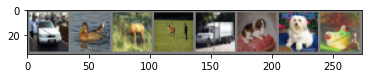

car, bird, deer, deer, truck, dog, dog, frog, 


In [137]:
def imshow(image):
  image = image / 2 + 0.5
  npimg = image.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[:8]))
print(''.join('{}, ' .format(classes[labels[j]]) for j in range(8)))

## 모델 정의 및 파라미터

In [138]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.cn1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.cn2 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.fc1 = nn.Linear(in_features=64*5*5, out_features=600)
    self.drop = nn.Dropout2d(0.25)
    self.fc2 = nn.Linear(in_features=600, out_features=120)
    self.fc3 = nn.Linear(in_features=120, out_features=10)

  def forward(self, inputs):
    out = self.cn1(inputs)
    out = self.cn2(out)
    out = out.view(out.size(0), -1)
    out = self.fc1(out)
    out = self.drop(out)
    out = self.fc2(out)
    out = self.fc3(out)
    return out

model = CNN().to(device)
print(model)

CNN(
  (cn1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cn2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1600, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [139]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## 모델 학습

In [140]:
loss_history = []
acc_history = []

for epoch in range(10):

  running_loss = 0.0
  running_corrects = 0

  for i, data in enumerate(train_loader, 0):
    inputs, labels = data[0].to(device), data[1].to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    _, preds = torch.max(outputs, 1)
    loss.backward()
    optimizer.step()

    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)

  epoch_loss = running_loss / len(train_loader.dataset)
  epoch_acc = running_corrects.to('cpu').numpy() / len(train_loader.dataset)
  print('Epoch: {}, Loss: {:.5}, Acc: {:.5f}' .format(epoch+1, epoch_loss, epoch_acc))

  loss_history.append(epoch_loss)
  acc_history.append(epoch_acc)

Epoch: 1, Loss: 1.4465, Acc: 0.48052
Epoch: 2, Loss: 1.102, Acc: 0.61158
Epoch: 3, Loss: 0.97684, Acc: 0.65902
Epoch: 4, Loss: 0.88362, Acc: 0.69186
Epoch: 5, Loss: 0.83329, Acc: 0.71062
Epoch: 6, Loss: 0.78067, Acc: 0.72952
Epoch: 7, Loss: 0.74147, Acc: 0.74240
Epoch: 8, Loss: 0.70293, Acc: 0.75590
Epoch: 9, Loss: 0.67696, Acc: 0.76510
Epoch: 10, Loss: 0.64517, Acc: 0.77536


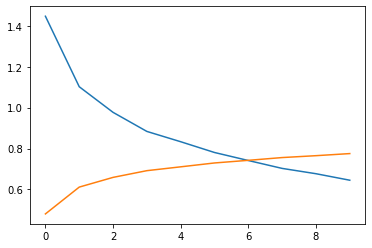

In [141]:
plt.plot(loss_history)
plt.plot(acc_history)
plt.show()

## 모델 평가

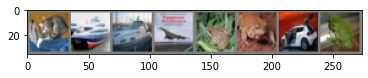

In [142]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[:8]))

In [143]:
images = images.to(device)
labels = labels.to(device)

outputs = model(images)

_, predicted = torch.max(outputs, 1)
print(predicted[:8])

tensor([3, 8, 8, 0, 6, 6, 1, 6], device='cuda:0')


In [148]:
print(''.join('{}, '.format(classes[int(predicted[j].to('cpu').numpy())]) for j in range(8)))

cat, ship, ship, plane, frog, frog, car, frog, 


In [149]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(100 * correct / total)

72.11


클래스별로 어떤 것을 잘 분류했고, 잘 못했는지 확인

In [150]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
  for data in test_loader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1

for i in range(10):
  print("Accuracy of {}: {}%".format(classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 74.33628318584071%
Accuracy of car: 75.65217391304348%
Accuracy of bird: 52.63157894736842%
Accuracy of cat: 44.96124031007752%
Accuracy of deer: 65.9090909090909%
Accuracy of dog: 65.48672566371681%
Accuracy of frog: 78.51239669421487%
Accuracy of horse: 82.03125%
Accuracy of ship: 85.84070796460178%
Accuracy of truck: 88.23529411764706%
